# Train Samples: 36000
# Val   Samples: 12000
# Test  Samples: 12000
Train unique classes: 60
Val   unique classes: 20
Test  unique classes: 20


C:\Users\Furkan\anaconda3\envs\pytorch\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Furkan\.cache\huggingface\hub\models--timm--vit_small_patch16_224.augreg_in21k_ft_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)



Visualizing some Train Samples:


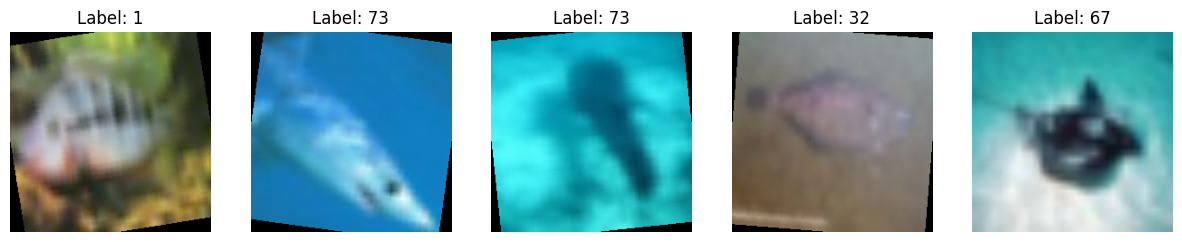


Visualizing some Val Samples:


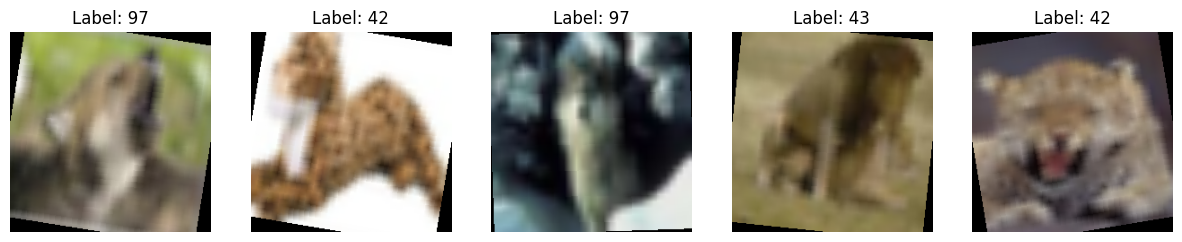


Starting Training...
Episode 1/1000, Loss: 0.327823, Accuracy: 93.33%, Time/Episode: 18.67s, Elapsed: 18.67s, Remaining: ~18653.55s
[Validation] Episode 10, Accuracy: 88.05%
[Validation] Episode 20, Accuracy: 80.85%
[Validation] Episode 30, Accuracy: 85.23%
[Validation] Episode 40, Accuracy: 86.00%
[Validation] Episode 50, Accuracy: 87.65%
Episode 51/1000, Loss: 0.131069, Accuracy: 94.67%, Time/Episode: 15.53s, Elapsed: 920.57s, Remaining: ~17129.76s
[Validation] Episode 60, Accuracy: 82.61%
[Validation] Episode 70, Accuracy: 84.91%
[Validation] Episode 80, Accuracy: 86.69%
[Validation] Episode 90, Accuracy: 87.25%
[Validation] Episode 100, Accuracy: 87.73%
Episode 101/1000, Loss: 0.161134, Accuracy: 96.00%, Time/Episode: 15.50s, Elapsed: 1828.51s, Remaining: ~16275.51s
[Validation] Episode 110, Accuracy: 87.47%
[Validation] Episode 120, Accuracy: 86.67%
[Validation] Episode 130, Accuracy: 86.05%
[Validation] Episode 140, Accuracy: 88.19%
[Validation] Episode 150, Accuracy: 88.67%
Epi

Evaluating: 100%|██████████| 100/100 [05:20<00:00,  3.21s/it]


Per-episode Accuracies:
 Episode  1: 88.00%
 Episode  2: 90.67%
 Episode  3: 78.67%
 Episode  4: 82.67%
 Episode  5: 80.00%
 Episode  6: 78.67%
 Episode  7: 82.67%
 Episode  8: 76.00%
 Episode  9: 90.67%
 Episode 10: 84.00%
 Episode 11: 81.33%
 Episode 12: 81.33%
 Episode 13: 77.33%
 Episode 14: 93.33%
 Episode 15: 82.67%
 Episode 16: 92.00%
 Episode 17: 84.00%
 Episode 18: 77.33%
 Episode 19: 93.33%
 Episode 20: 74.67%
 Episode 21: 89.33%
 Episode 22: 89.33%
 Episode 23: 82.67%
 Episode 24: 76.00%
 Episode 25: 86.67%
 Episode 26: 78.67%
 Episode 27: 68.00%
 Episode 28: 74.67%
 Episode 29: 74.67%
 Episode 30: 69.33%
 Episode 31: 53.33%
 Episode 32: 73.33%
 Episode 33: 89.33%
 Episode 34: 88.00%
 Episode 35: 60.00%
 Episode 36: 90.67%
 Episode 37: 81.33%
 Episode 38: 89.33%
 Episode 39: 70.67%
 Episode 40: 85.33%
 Episode 41: 68.00%
 Episode 42: 81.33%
 Episode 43: 80.00%
 Episode 44: 76.00%
 Episode 45: 90.67%
 Episode 46: 73.33%
 Episode 47: 69.33%
 Episode 48: 92.00%
 Episode 49: 77

In [2]:
import os
import time
import torch
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from PIL import Image
from tqdm import tqdm
from collections import defaultdict

from torch.utils.data import Dataset
import torchvision.transforms as transforms

import timm
from timm.models.vision_transformer import VisionTransformer
from timm.models.layers import to_2tuple

# 1. Enable Synchronous CUDA Error Reporting
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

# 2. Define Constants
FC100_PATH = r"C:\Users\Furkan\Desktop\fc100"  # Folder where pickles are stored
TRAIN_PICKLE = os.path.join(FC100_PATH, "FC100_train.pickle")
VAL_PICKLE   = os.path.join(FC100_PATH, "FC100_val.pickle")
TEST_PICKLE  = os.path.join(FC100_PATH, "FC100_test.pickle")

IMG_SIZE = 224
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

EPISODES = 1000   # Number of training episodes
SHOTS = 5
QUERY = 15
NUM_CLASSES_PER_EPISODE = 5

EVAL_FREQUENCY = 10

# 3. Custom Dataset for FC100
class FC100Dataset(Dataset):
    def __init__(self, pickle_path, transform=None):
        # Use 'latin1' (or 'bytes') if pickle was created in Python 2 or contains
        # binary data that doesn't map to ASCII.
        with open(pickle_path, 'rb') as handle:
            data_dict = pickle.load(handle, encoding='latin1')
        
        self.images = data_dict["data"]   # shape: [N, H, W, C]
        self.labels = data_dict["labels"] # shape: [N]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_np = self.images[idx]  # e.g. shape (84, 84, 3)
        label  = self.labels[idx]

        # Convert numpy array to PIL Image
        img = Image.fromarray(img_np.astype('uint8'), 'RGB')

        # Apply transform if any
        if self.transform:
            img = self.transform(img)

        return img, label


# 4. Define Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# 5. Create Train/Val/Test Datasets
train_dataset = FC100Dataset(TRAIN_PICKLE, transform=transform)
val_dataset   = FC100Dataset(VAL_PICKLE,   transform=transform)
test_dataset  = FC100Dataset(TEST_PICKLE,  transform=transform)

print(f"# Train Samples: {len(train_dataset)}")
print(f"# Val   Samples: {len(val_dataset)}")
print(f"# Test  Samples: {len(test_dataset)}")

# 6. Create class_to_indices for train, val, test
class_to_indices_train = defaultdict(list)
for idx in range(len(train_dataset)):
    _, lbl = train_dataset[idx]
    class_to_indices_train[lbl].append(idx)

class_to_indices_val = defaultdict(list)
for idx in range(len(val_dataset)):
    _, lbl = val_dataset[idx]
    class_to_indices_val[lbl].append(idx)

class_to_indices_test = defaultdict(list)
for idx in range(len(test_dataset)):
    _, lbl = test_dataset[idx]
    class_to_indices_test[lbl].append(idx)

print(f"Train unique classes: {len(class_to_indices_train)}")
print(f"Val   unique classes: {len(class_to_indices_val)}")
print(f"Test  unique classes: {len(class_to_indices_test)}")

# -------------------------------------------------------------
# 7. Define a Pretrained ViT that includes Dropout
# -------------------------------------------------------------
class PretrainedViTWithAttention(VisionTransformer):
    def __init__(self, num_classes, pretrained=True, drop_rate=0.1):
        # vit_small_patch16_224 has embed_dim=384, num_heads=6, depth=12
        super().__init__(
            img_size=224,
            patch_size=16,
            in_chans=3,
            num_classes=num_classes,
            embed_dim=384,
            depth=12,
            num_heads=6,
            mlp_ratio=4.0,
            qkv_bias=True,
            norm_layer=torch.nn.LayerNorm,
            drop_rate=drop_rate   # Add dropout
        )
        if pretrained:
            # Create a smaller timm ViT backbone with no classification head
            base_model = timm.create_model(
                "vit_small_patch16_224",
                pretrained=True,
                num_classes=0,
                drop_rate=drop_rate
            )
            state_dict = base_model.state_dict()
            self.load_state_dict(state_dict, strict=False)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # classification head
        return x

    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x[:, 0]  # CLS token

# 8. Initialize Model
all_labels = set(class_to_indices_train.keys()) | set(class_to_indices_val.keys()) | set(class_to_indices_test.keys())
num_all_labels = len(all_labels)

model = PretrainedViTWithAttention(
    num_classes=num_all_labels,
    pretrained=True,
    drop_rate=0.1
).to(DEVICE)

# 9. ProtoNets Utilities
def compute_prototypes(features, labels):
    unique_labels = torch.unique(labels)
    prototypes = []
    for ul in unique_labels:
        class_features = features[labels == ul]
        prototypes.append(class_features.mean(dim=0))
    return torch.stack(prototypes), unique_labels

def classify(features, prototypes):
    # Negative Euclidean distance => "logits"
    dists = torch.cdist(features, prototypes)  # [batch_size, num_classes_in_episode]
    return -dists

def clip_gradients(optimizer, max_norm=1.0):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                torch.nn.utils.clip_grad_norm_(param, max_norm)

def debug_batch(images, labels, logits, loss):
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")
    print(f"Logits: {logits}")
    print(f"Loss: {loss}")

# 10. Episodic Batch
def episodic_batch_custom(dataset, class_to_indices, shots, query, num_classes_per_episode=5):
    """ 
    Create an episodic batch from 'dataset' given the label->indices dictionary 'class_to_indices'.
    """
    # Randomly select N classes for the episode
    selected_classes = random.sample(list(class_to_indices.keys()), num_classes_per_episode)

    support_images, support_labels = [], []
    query_images, query_labels = [], []

    for cls in selected_classes:
        indices = class_to_indices[cls]
        if len(indices) < (shots + query):
            raise ValueError(f"Not enough samples for class '{cls}' "
                             f"(need {shots + query}, have {len(indices)})")

        chosen = random.sample(indices, shots + query)
        s_idx = chosen[:shots]
        q_idx = chosen[shots:]

        for i in s_idx:
            image, label = dataset[i]
            support_images.append(image)
            support_labels.append(label)

        for i in q_idx:
            image, label = dataset[i]
            query_images.append(image)
            query_labels.append(label)

    support_images = torch.stack(support_images).to(DEVICE)
    support_labels = torch.tensor(support_labels, dtype=torch.long).to(DEVICE)
    query_images   = torch.stack(query_images).to(DEVICE)
    query_labels   = torch.tensor(query_labels, dtype=torch.long).to(DEVICE)

    return support_images, support_labels, query_images, query_labels

# 11. Train Function
def train_prototypical_network_custom(
    model,
    train_dataset,
    class_to_indices_train,
    val_dataset,
    class_to_indices_val,
    optimizer,
    criterion,
    episodes,
    shots,
    query,
    num_classes_per_episode=5,
    eval_freq=50
):
    model.train()
    start_time = time.time()

    for episode in range(1, episodes + 1):
        episode_start = time.time()

        try:
            support_images, support_labels, query_images, query_labels = episodic_batch_custom(
                train_dataset,
                class_to_indices_train,
                shots,
                query,
                num_classes_per_episode
            )

            # Forward
            support_feats = model.forward_features(support_images)
            query_feats   = model.forward_features(query_images)

            prototypes, unique_labels_ep = compute_prototypes(support_feats, support_labels)
            logits = classify(query_feats, prototypes)

            # Map global labels to local (episode) labels
            mapped_query_labels = torch.zeros_like(query_labels)
            for idx_local, label_global in enumerate(unique_labels_ep):
                mapped_query_labels[query_labels == label_global] = idx_local

            loss = criterion(logits, mapped_query_labels)

            # Compute accuracy
            preds = torch.argmax(logits, dim=1)
            train_acc = (preds == mapped_query_labels).float().mean().item()

            # Safety check
            if torch.isnan(loss) or torch.isinf(loss):
                debug_batch(query_images, query_labels, logits, loss)
                raise ValueError("Loss is NaN or Inf")

            optimizer.zero_grad()
            loss.backward()
            clip_gradients(optimizer)
            optimizer.step()

        except Exception as e:
            print(f"Error in episode {episode}: {e}")
            continue

        # Print training info
        episode_end = time.time()
        duration = episode_end - episode_start

        # Print occasionally
        if episode % 50 == 1 or episode == 1:
            elapsed = episode_end - start_time
            avg_per_episode = elapsed / episode
            remaining = (episodes - episode) * avg_per_episode
            print(f"Episode {episode}/{episodes}, "
                  f"Loss: {loss.item():.6f}, "
                  f"Accuracy: {train_acc * 100:.2f}%, "
                  f"Time/Episode: {duration:.2f}s, "
                  f"Elapsed: {elapsed:.2f}s, "
                  f"Remaining: ~{remaining:.2f}s")

        # Evaluate periodically (no early stopping)
        if episode % eval_freq == 0:
            val_acc, _, _ = evaluate_prototypical_network_custom(
                model,
                val_dataset,
                class_to_indices_val,
                shots,
                query,
                episodes=50,
                num_classes_per_episode=num_classes_per_episode,
                verbose=False
            )
            print(f"[Validation] Episode {episode}, Accuracy: {val_acc*100:.2f}%")

# 12. Eval Function
def evaluate_prototypical_network_custom(
    model,
    test_dataset,
    class_to_indices_test,
    shots,
    query,
    episodes,
    num_classes_per_episode=5,
    verbose=True
):
    model.eval()
    per_episode_accuracies = []

    with torch.no_grad():
        iterator = range(1, episodes + 1)
        if verbose:
            iterator = tqdm(iterator, desc="Evaluating")

        for _ in iterator:
            try:
                s_imgs, s_lbls, q_imgs, q_lbls = episodic_batch_custom(
                    test_dataset,
                    class_to_indices_test,
                    shots,
                    query,
                    num_classes_per_episode
                )
                s_feats = model.forward_features(s_imgs)
                q_feats = model.forward_features(q_imgs)
                prototypes, unique_labels_ep = compute_prototypes(s_feats, s_lbls)
                logits = classify(q_feats, prototypes)

                # Map global to local
                mapped_q_labels = torch.zeros_like(q_lbls)
                for i_local, g_label in enumerate(unique_labels_ep):
                    mapped_q_labels[q_lbls == g_label] = i_local

                preds_local = torch.argmax(logits, dim=1)
                preds_global = unique_labels_ep[preds_local]

                correct_this_episode = (preds_global == q_lbls).sum().item()
                total_this_episode   = q_lbls.size(0)
                episode_acc = correct_this_episode / total_this_episode
                per_episode_accuracies.append(episode_acc)

            except Exception as e:
                if verbose:
                    print("Eval error:", e)
                # If there's an error, skip this episode
                continue

    if len(per_episode_accuracies) == 0:
        if verbose:
            print("No episodes successfully evaluated.")
        return 0.0, 0.0, []

    # Average accuracy
    avg_acc = np.mean(per_episode_accuracies)
    # Standard deviation
    std_dev = np.std(per_episode_accuracies, ddof=1)
    # 95% Confidence Interval
    ci95 = 1.96 * (std_dev / np.sqrt(len(per_episode_accuracies)))

    if verbose:
        print("\nPer-episode Accuracies:")
        for i, ep_acc in enumerate(per_episode_accuracies, 1):
            print(f" Episode {i:2d}: {ep_acc*100:.2f}%")

        print(f"\nAverage Accuracy: {avg_acc*100:.2f}%")
        print(f"95% CI: ±{ci95*100:.2f}%")

    return avg_acc, ci95, per_episode_accuracies

# 13. (Optional) Visualization
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(15, 3))
    count = 0
    for i in range(len(dataset)):
        if count >= num_samples:
            break
        img, lbl = dataset[i]
        # Convert image from tensor to numpy for plotting
        if isinstance(img, torch.Tensor):
            img_np = img.cpu().numpy().transpose(1,2,0)
            # Unnormalize
            img_np = (img_np * 0.5) + 0.5
        else:
            # If it's a PIL Image (depending on transforms), convert directly
            img_np = np.array(img)

        plt.subplot(1, num_samples, count+1)
        plt.imshow(img_np)
        plt.title(f"Label: {lbl}")
        plt.axis('off')
        count += 1
    plt.show()

# 14. Create Optimizer & Criterion
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

# 15. Visualize some samples (optional)
print("\nVisualizing some Train Samples:")
visualize_samples(train_dataset, num_samples=5)

print("\nVisualizing some Val Samples:")
visualize_samples(val_dataset, num_samples=5)

# 16. Train the Prototypical Network
print("\nStarting Training...")
train_prototypical_network_custom(
    model=model,
    train_dataset=train_dataset,
    class_to_indices_train=class_to_indices_train,
    val_dataset=val_dataset,
    class_to_indices_val=class_to_indices_val,
    optimizer=optimizer,
    criterion=criterion,
    episodes=EPISODES,
    shots=SHOTS,
    query=QUERY,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE,
    eval_freq=EVAL_FREQUENCY
)

# 17. Final Evaluation on Test Set
print("\nFinal Evaluation on Test Set...")
test_avg_acc, test_ci95, per_episode_accs = evaluate_prototypical_network_custom(
    model=model,
    test_dataset=test_dataset,
    class_to_indices_test=class_to_indices_test,
    shots=SHOTS,
    query=QUERY,
    episodes=100,
    num_classes_per_episode=NUM_CLASSES_PER_EPISODE
)

# 18. Save the Trained Model
save_path = os.path.join(FC100_PATH, "prototypical_network_vit_small_fc100.pth")
torch.save(model.state_dict(), save_path)
print(f"Model saved at {save_path}")
